In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from PIL import Image
import copy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Paths to your dataset folders
train_dir = '/content/drive/MyDrive/Dog_heart/Train'
valid_dir = '/content/drive/MyDrive/Dog_heart/Valid'
test_dir = '/content/drive/MyDrive/Dog_heart/Test'

# Data Augmentation for Training
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation and Test Transformations
valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Training and Validation Datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transforms)

# Handling Class Imbalance with WeightedRandomSampler
class_counts = [657, 622, 223]  # Replace with actual counts from your data
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders for Training and Validation
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

# Class Names
class_names = train_dataset.classes
print(f"Class Names: {class_names}")

# Custom Dataset for Test Data
class CustomTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(img_path)

test_dataset = CustomTestDataset(test_dir, transform=valid_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the Model
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch, channels, _, _ = x.size()
        y = self.global_avg_pool(x).view(batch, channels)
        y = self.fc(y).view(batch, channels, 1, 1)
        return x * y

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        identity = self.skip(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        return self.relu(out)

class CustomCNNWithAttention(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNNWithAttention, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2),
            SEBlock(32)
        )
        self.conv_block2 = ResidualBlock(32, 64)
        self.conv_block3 = ResidualBlock(64, 128)
        self.conv_block4 = ResidualBlock(128, 256)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomCNNWithAttention(num_classes=len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=10, mode='triangular'
)

# Training Function
def train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs=150):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        valid_loss = running_loss / len(valid_loader.dataset)
        valid_acc = running_corrects.double() / len(valid_loader.dataset)
        print(f"Valid Loss: {valid_loss:.4f} Acc: {valid_acc:.4f}")

        if valid_acc > best_acc:
            best_acc = valid_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step(valid_loss)

    print(f"Best Validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

# Train the Model
trained_model = train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs=75)

# Save the Model
torch.save(trained_model.state_dict(), 'dog_heart_model.pt')
print("Model saved as 'dog_heart_model.pt'")

# Predict Function
def predict(model, test_loader, class_names):
    model.eval()
    predictions = []
    file_names = []

    with torch.no_grad():
        for inputs, names in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            file_names.extend(names)

    return predictions, file_names

test_predictions, file_names = predict(trained_model, test_loader, class_names)

# Save Predictions to CSV
output_csv = 'predictions.csv'
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['File Name', 'Predicted Class'])
    for i in range(len(file_names)):
        writer.writerow([file_names[i], class_names[test_predictions[i]]])

print(f"Predictions saved to {output_csv}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class Names: ['Large', 'Normal', 'Small']
Epoch 1/75
----------
Train Loss: 1.1276 Acc: 0.3431
Valid Loss: 1.0747 Acc: 0.3800
Epoch 2/75
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Loss: 1.1001 Acc: 0.3903
Valid Loss: 1.0107 Acc: 0.4650
Epoch 3/75
----------
Train Loss: 1.0512 Acc: 0.4354
Valid Loss: 1.0653 Acc: 0.4100
Epoch 4/75
----------
Train Loss: 1.0131 Acc: 0.4689
Valid Loss: 1.0684 Acc: 0.3550
Epoch 5/75
----------
Train Loss: 0.9651 Acc: 0.4949
Valid Loss: 1.0841 Acc: 0.4400
Epoch 6/75
----------
Train Loss: 0.9378 Acc: 0.5140
Valid Loss: 1.7020 Acc: 0.2100
Epoch 7/75
----------
Train Loss: 0.9172 Acc: 0.5530
Valid Loss: 0.9482 Acc: 0.4900
Epoch 8/75
----------
Train Loss: 0.8699 Acc: 0.5571
Valid Loss: 0.9569 Acc: 0.5100
Epoch 9/75
----------
Train Loss: 0.8317 Acc: 0.5748
Valid Loss: 0.8070 Acc: 0.5200
Epoch 10/75
----------
Train Loss: 0.8243 Acc: 0.5810
Valid Loss: 0.8657 Acc: 0.5300
Epoch 11/75
----------
Train Loss: 0.8187 Acc: 0.5940
Valid Loss: 0.7879 Acc: 0.5100
Epoch 12/75
----------
Train Loss: 0.7910 Acc: 0.6186
Valid Loss: 0.7604 Acc: 0.5550
Epoch 13/75
----------
Train Loss: 0.7420 Acc: 0.6323
Valid Loss: 0.9121 Acc: 0.5300
Epoch 14/7

### Github link 

https://github.com/PremchandJalla/Dog-Cardiomegaly

### Results 

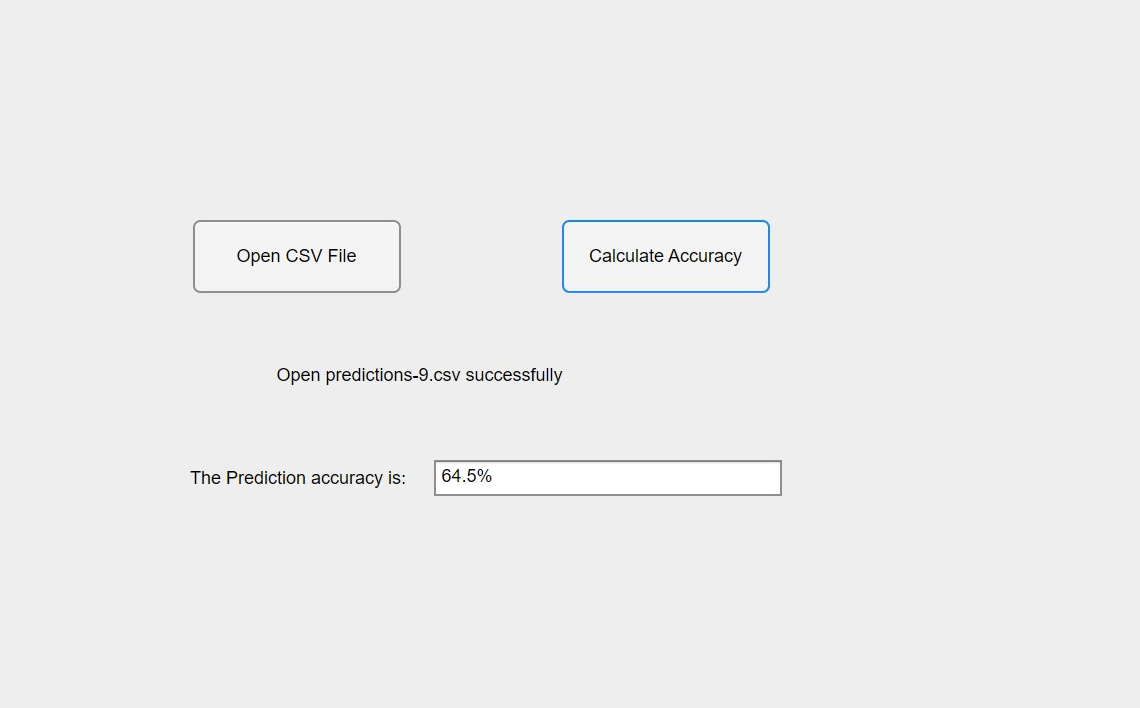blob:https://web.whatsapp.com/ef3b23e3-4b86-49c6-b8af-e304a9165697